In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import torchvision.models.segmentation as models
from torchvision.models.optical_flow import raft_large

from lumivid.sky_ground_segmentation.train import get_model as get_ground_model
from lumivid.utils.video_utils import get_video, get_video_frame_iterator
from lumivid.utils.model_utils import load_model

DATA_PATH = '../data/'

FRAME_STEP = 25

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
segmentation_classes = {
    0: 0, # background
    1: 0, # aeroplane
    2: 1, # bicycle
    3: 0, # bird
    4: 1, # boat
    5: 0, # bottle
    6: 1, # bus
    7: 1, # car
    8: 0, # cat
    9: 0, # chair
    10: 0, # cow
    11: 0, # dining table
    12: 0, # dog
    13: 0, # horse
    14: 1, # motorbike
    15: 2, # person
    16: 0, # potted plant
    17: 0, # sheep
    18: 0, # sofa
    19: 1, # train
    20: 0, # tv/monitor
}
segmentation_map = {
    0: 'background',
    1: 'vehicle',
    2: 'person',
}

segmentation_color_map = {
    0: (0, 0, 0),
    1: (0, 0, 255),
    2: (255, 0, 0),
}

def show_flow_segmentation(rgb_frame, segmentation_frame, optical_flow, step: int = 10, alpha: float = 0.5):
    # Map the segmentation classes to the corresponding colors
    segmentation_colors = np.vectorize(segmentation_color_map.get)(segmentation_frame)
    segmentation_colors = np.array(segmentation_colors, dtype=np.uint8).transpose(1, 2, 0)
    rgb_mixed = np.where(segmentation_colors.sum(axis=2)[..., np.newaxis] == 0, rgb_frame, rgb_frame * (1 - alpha) + segmentation_colors * alpha)
    rgb_mixed = rgb_mixed.astype(np.uint8)

    # Downsample the flow for a cleaner quiver plot
    optical_flow_downsampled = optical_flow[::step, ::step]
    y, x = np.mgrid[0:rgb_mixed.shape[0]:step, 0:rgb_mixed.shape[1]:step]

    # Get the colors for the downsampled segmentation at the points where we will place the quiver arrows
    colors_for_quiver = segmentation_colors[y.flatten(), x.flatten()]

    # Normalize the color values
    quiver_colors = colors_for_quiver / 255.0

    # Plot the flow vectors
    plt.figure(figsize=(20, 20))
    plt.quiver(x.flatten(), y.flatten(), optical_flow_downsampled[..., 0].flatten(), optical_flow_downsampled[..., 1].flatten(), 
               angles='xy', scale_units='xy', scale=0.25, color=quiver_colors, width=0.0015)
    plt.imshow(rgb_mixed, interpolation='none')
    plt.show()


def get_ground_mask(rgb_frame, model_type='deeplabv3mobilenetv3large', optimizer_type='ranger', shape_factor=1):
    # Load model
    model_save_path = f"../data/sky_ground_segmentation/models/{model_type}_{optimizer_type}_pretrained.pth"
    ground_model = get_ground_model(model_type, n_classes=2, pretrained=False)
    load_model(ground_model, model_save_path, force=True)
    ground_model.eval()
    
    old_shape = (rgb_frame.shape[0], rgb_frame.shape[1])
    new_shape = (old_shape[0] // shape_factor, old_shape[1] // shape_factor)

    # Get tensor from frame
    frame_tensor = torch.tensor(rgb_frame).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE) # To tensor
    transforms = T.Compose([
        T.ConvertImageDtype(torch.float32),
        T.Lambda(lambda x: x / 255.0),                      # [0, 255] to [0, 1]
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),  # [0, 1] to [-1, 1]
        T.Resize(size=(new_shape[0], new_shape[1])),
    ])
    frame_tensor = transforms(frame_tensor)

    # Get segmentation mask
    with torch.no_grad():
        ground_mask = ground_model(frame_tensor)['out'].cpu().numpy().squeeze()
        ground_mask = ground_mask.argmax(0)

        # Resize segmentation mask to original shape
        ground_mask = cv2.resize(ground_mask, (old_shape[1], old_shape[0]), interpolation=cv2.INTER_NEAREST)

    # Free GPU memory
    del ground_model
    del frame_tensor
    torch.cuda.empty_cache()

    return ground_mask.astype(bool)

def get_segmentation_model():
    """
    return models.deeplabv3_mobilenet_v3_large(
        weights='COCO_WITH_VOC_LABELS_V1',
        weights_backbone='IMAGENET1K_V2',
        progress=True,
        num_classes=21,
        aux_loss=True
    ).to(DEVICE)
    """
    return models.deeplabv3_resnet101(
        weights='COCO_WITH_VOC_LABELS_V1',
        weights_backbone='IMAGENET1K_V2',
        progress=True,
        num_classes=21,
        aux_loss=True
    ).to(DEVICE)

def get_segmented_frame(segmentation_model, rgb_frame, ground_mask, shape_factor=1):
    segmentation_model.eval()

    old_shape = (rgb_frame.shape[0], rgb_frame.shape[1])
    new_shape = (old_shape[0] // shape_factor, old_shape[1] // shape_factor)

    # Get tensor from frame
    frame_tensor = torch.from_numpy(rgb_frame).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    transforms = T.Compose([
        T.Lambda(lambda x: x / 255.0),      # [0, 255] to [0, 1]
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), # [0, 1] to [-1, 1]
        T.Resize(size=(new_shape[0], new_shape[1])),
    ])
    frame_tensor = transforms(frame_tensor)

    # Get segmentation mask
    with torch.no_grad():
        output = segmentation_model(frame_tensor)['out']
        output = output.argmax(1).squeeze().cpu().numpy()

        # Resize segmentation mask to original shape
        output = cv2.resize(output, (old_shape[1], old_shape[0]), interpolation=cv2.INTER_NEAREST)

        # Apply ground mask
        output = output * ground_mask

    # Free GPU memory
    del frame_tensor
    torch.cuda.empty_cache()

    return output

def get_optical_flow_model():
    return raft_large(weights='C_T_SKHT_V2').to(DEVICE)

def get_flow(optical_flow_model, rgb_frame1, rgb_frame2, ground_mask, shape_factor=2, multiple=8):
    optical_flow_model.eval()

    old_shape = (rgb_frame1.shape[0], rgb_frame1.shape[1])
    new_shape = ((old_shape[0] // (shape_factor * multiple)) * multiple, (old_shape[1] // (shape_factor * multiple)) * multiple)

    # Get tensor from frame
    frame1_tensor = torch.from_numpy(rgb_frame1).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    frame2_tensor = torch.from_numpy(rgb_frame2).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    transforms = T.Compose([
        T.Lambda(lambda x: x / 255.0),      # [0, 255] to [0, 1]
        T.Normalize(mean=[0.5], std=[0.5]), # [0, 1] to [-1, 1]
        T.Resize(size=(new_shape[0], new_shape[1])),
    ])
    frame1_tensor = transforms(frame1_tensor)
    frame2_tensor = transforms(frame2_tensor)

    with torch.no_grad():
        optical_flow = optical_flow_model(frame1_tensor, frame2_tensor)
        optical_flow = optical_flow[0].squeeze().cpu().numpy()

        # Resize flow to original shape
        optical_flow = optical_flow.transpose(1, 2, 0)
        optical_flow = cv2.resize(optical_flow, (old_shape[1], old_shape[0]))

        # Apply ground mask
        optical_flow = optical_flow * ground_mask[:, :, np.newaxis]

    # Free GPU memory
    del frame1_tensor
    del frame2_tensor
    torch.cuda.empty_cache()

    return optical_flow

In [5]:
def show_ground_statistics(
        video_path: str,
        segmentation_model,
        optical_flow_model,
        frame_step: int = 1,
        split: bool = False,
        masked: bool = False,
        reframed: bool = False
    ):
    video = get_video(video_path)
    frame_it = get_video_frame_iterator(
        video, 
        frame_step=frame_step,
        split = split,
        masked = masked,
        reframed = reframed
    )

    # Statistics initialization
    class_magnitudes = [0] * len(segmentation_map)

    previous_rgb_frame = None
    ground_mask = None
    n_frames = 0
    for frame, _ in tqdm(frame_it):
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # BGR to RGB

        # Get ground mask
        if ground_mask is None:
            ground_mask = get_ground_mask(rgb_frame)
            ground_mask = ~ground_mask # Invert mask

        # Reframe shape like previous frame if needed
        if previous_rgb_frame is not None and frame.shape != previous_rgb_frame.shape:
            rgb_frame = cv2.resize(rgb_frame, (previous_rgb_frame.shape[1], previous_rgb_frame.shape[0]))

        # Get ground frame
        rgb_frame = rgb_frame * ground_mask[:, :, np.newaxis] # Apply ground mask to frame

        # Get statistics
        if previous_rgb_frame is not None:
            # Get segmentation mask
            segmentation_frame = get_segmented_frame(segmentation_model, previous_rgb_frame, ground_mask)
            segmentation_frame = segmentation_frame.astype(int)
            segmentation_frame = np.vectorize(segmentation_classes.get)(segmentation_frame)

            # Get optical flow
            optical_flow = get_flow(optical_flow_model, previous_rgb_frame, rgb_frame, ground_mask)
            magnitudes = np.linalg.norm(optical_flow, axis=2)

            # Get statistics
            for class_id in segmentation_map.keys():
                class_magnitudes[class_id] += magnitudes[segmentation_frame == class_id].sum()

            show_flow_segmentation(previous_rgb_frame, segmentation_frame, optical_flow)

        previous_rgb_frame = rgb_frame
        n_frames += 1

    # Normalize statistics
    all_class_magnitudes = np.array(class_magnitudes)
    all_class_magnitudes = all_class_magnitudes / n_frames

    object_class_magnitudes = all_class_magnitudes[1:]
    object_class_magnitudes = object_class_magnitudes / n_frames

    # Show statistics
    colors = [segmentation_color_map[class_id] for class_id in segmentation_map.keys()]
    colors = np.array(colors) / 255.0

    # Create the figure and subplots
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title('All classes')
    plt.bar(list(segmentation_map.values()), all_class_magnitudes, color=colors)
    plt.subplot(1, 2, 2)
    plt.title('Object classes')
    plt.bar(list(segmentation_map.values())[1:], object_class_magnitudes, color=colors[1:])
    plt.show()

    return all_class_magnitudes, object_class_magnitudes


In [6]:
segmentation_model = get_segmentation_model()
optical_flow_model = get_optical_flow_model()

In [7]:
scene_type = 'raw_scenes'
final_statistics = {}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


c:\Users\arnau\anaconda3\envs\a\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


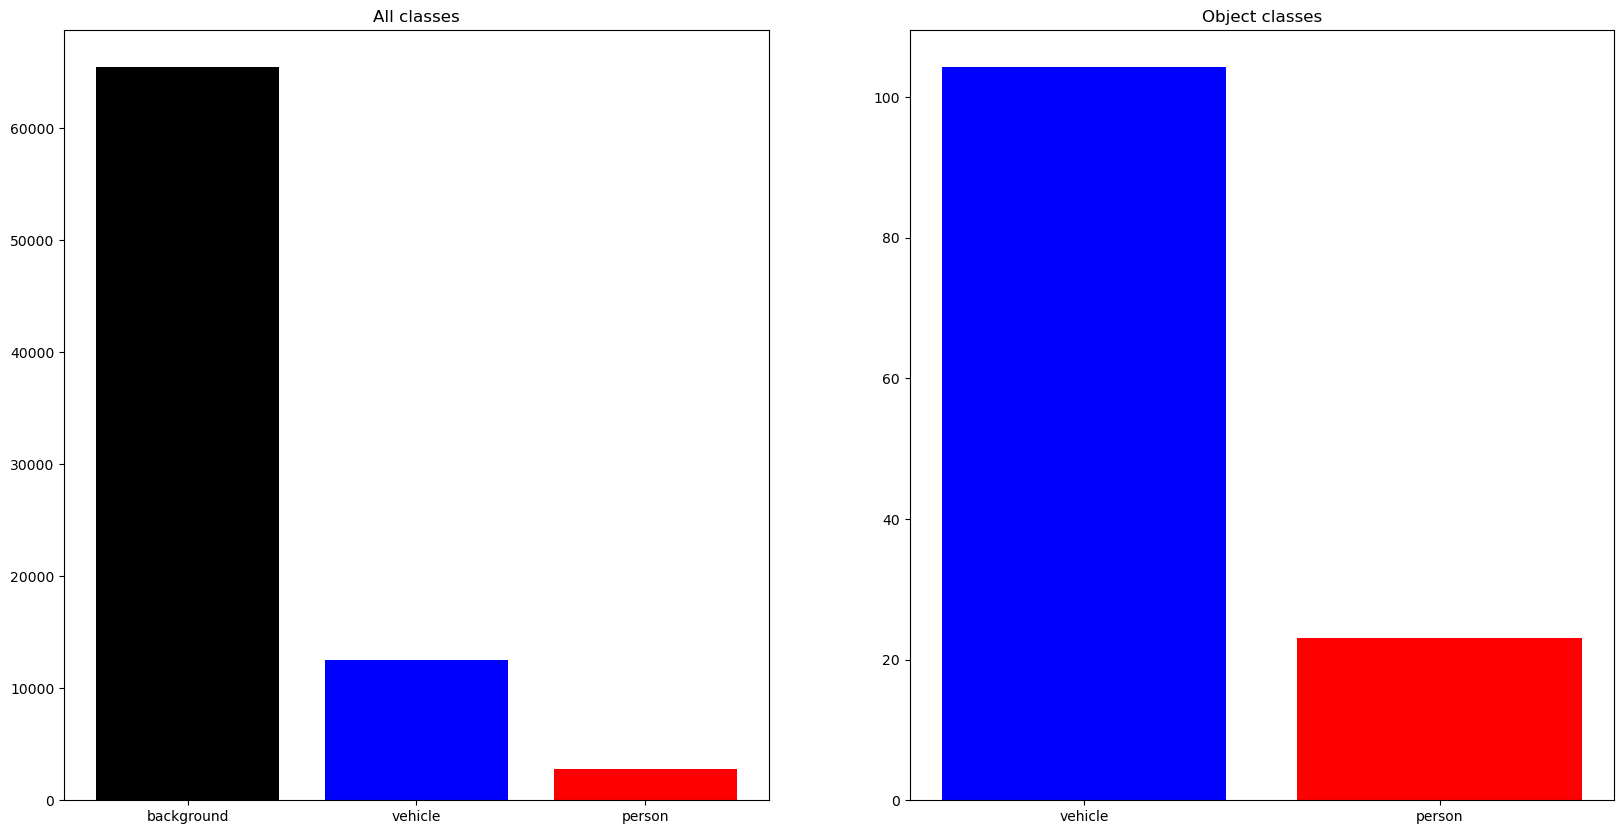

In [96]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene01.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


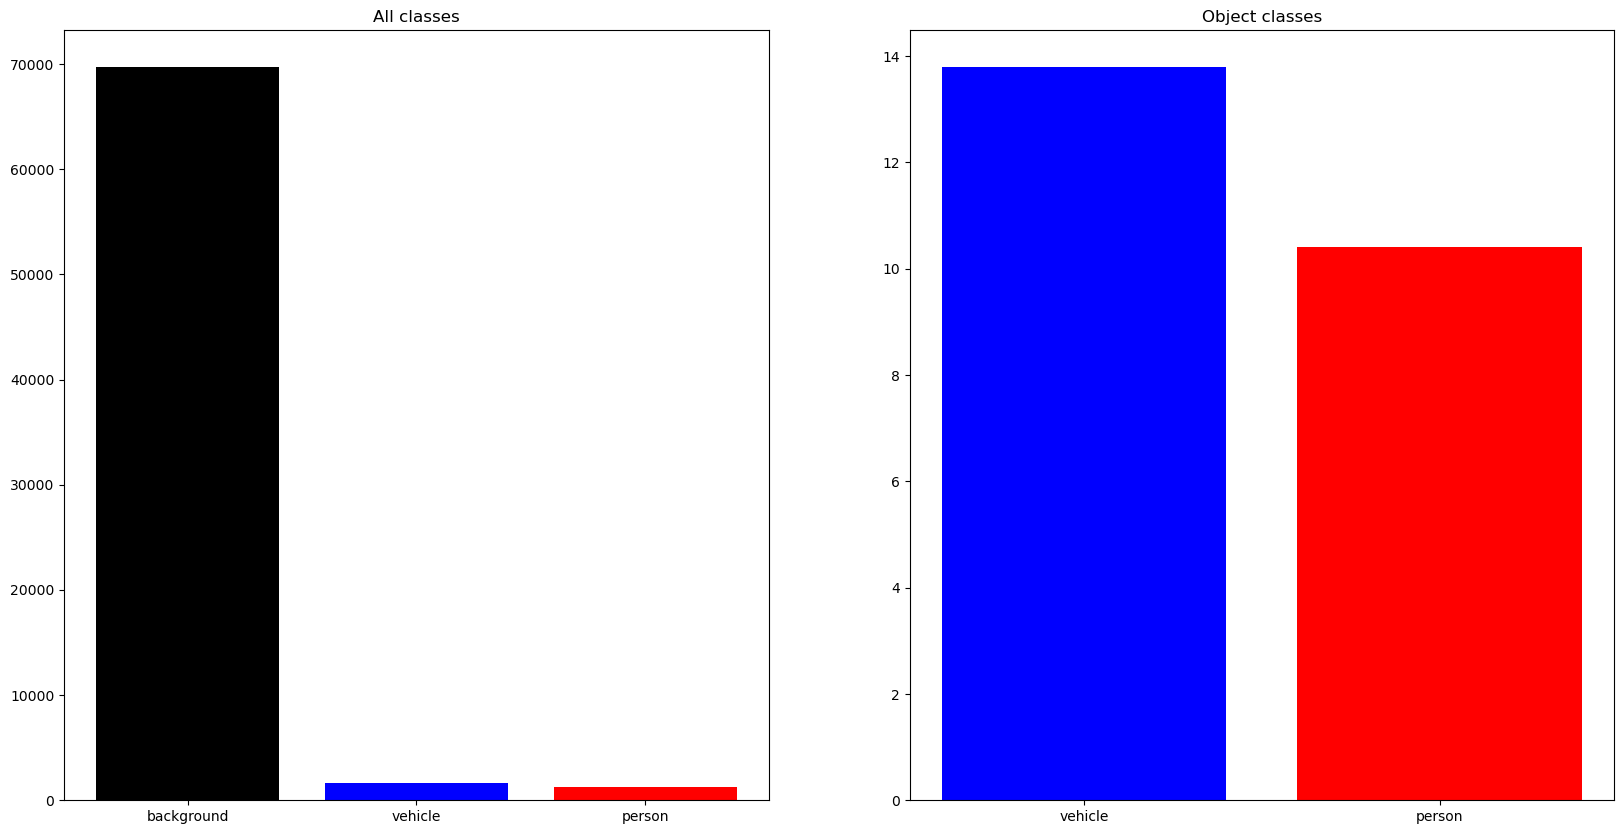

In [97]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene02.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


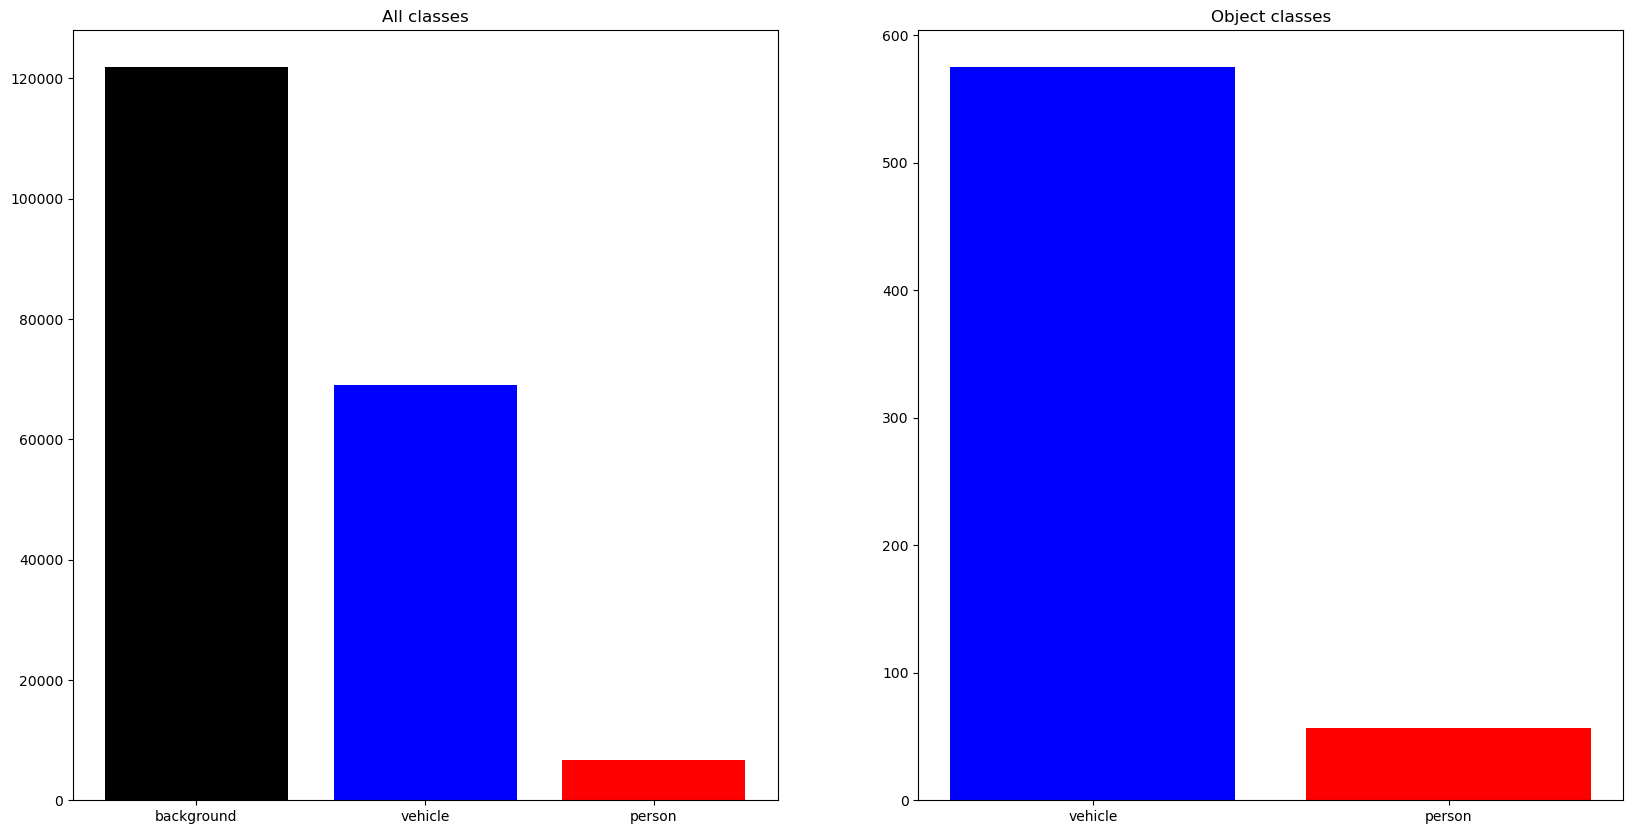

In [98]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene03.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


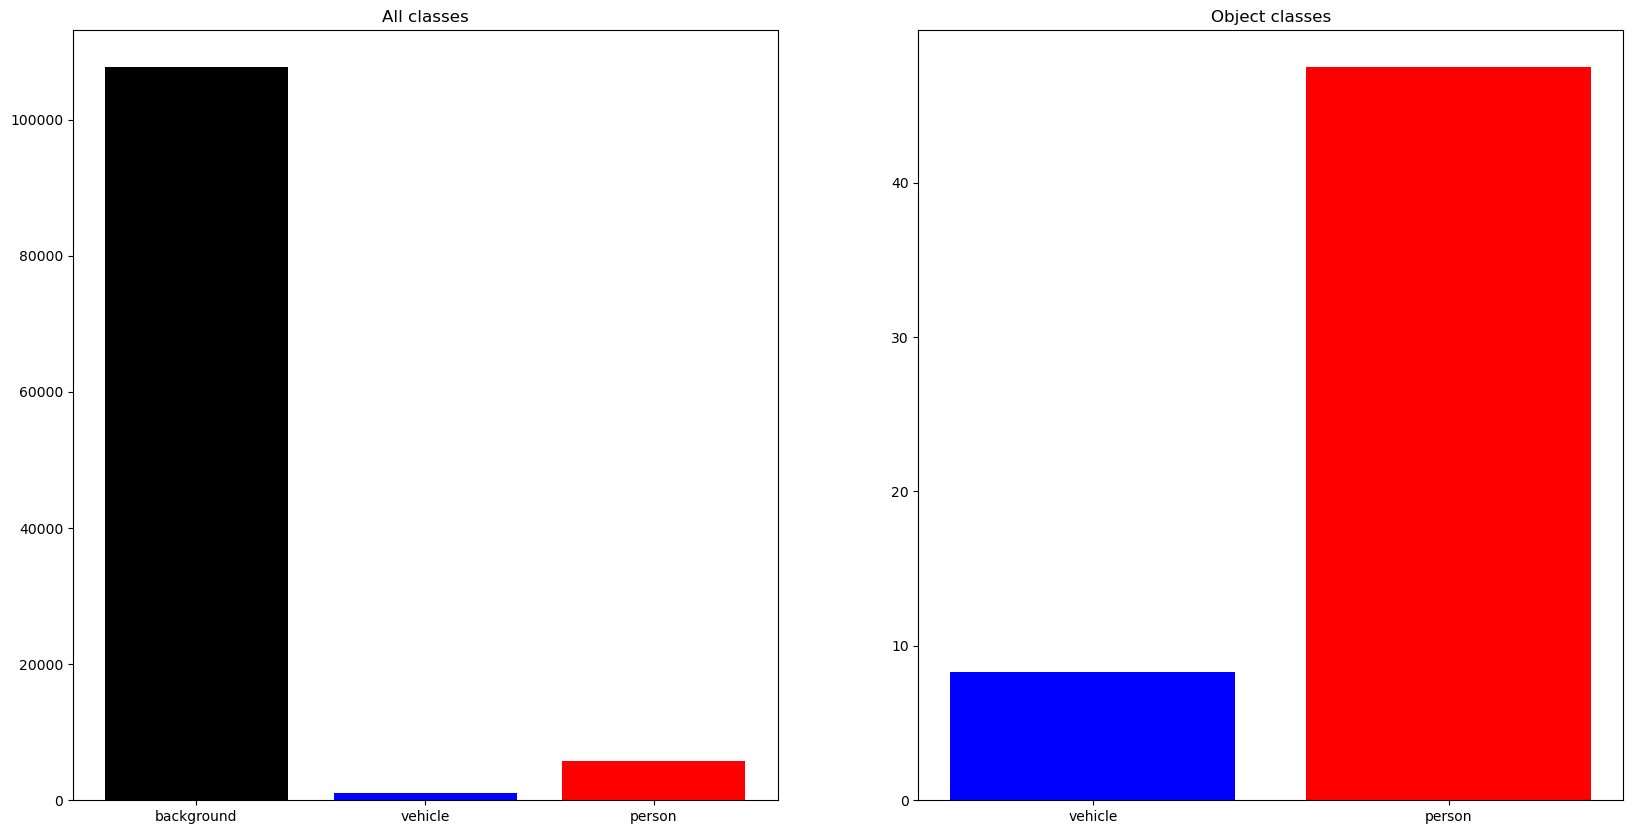

In [99]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene04.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


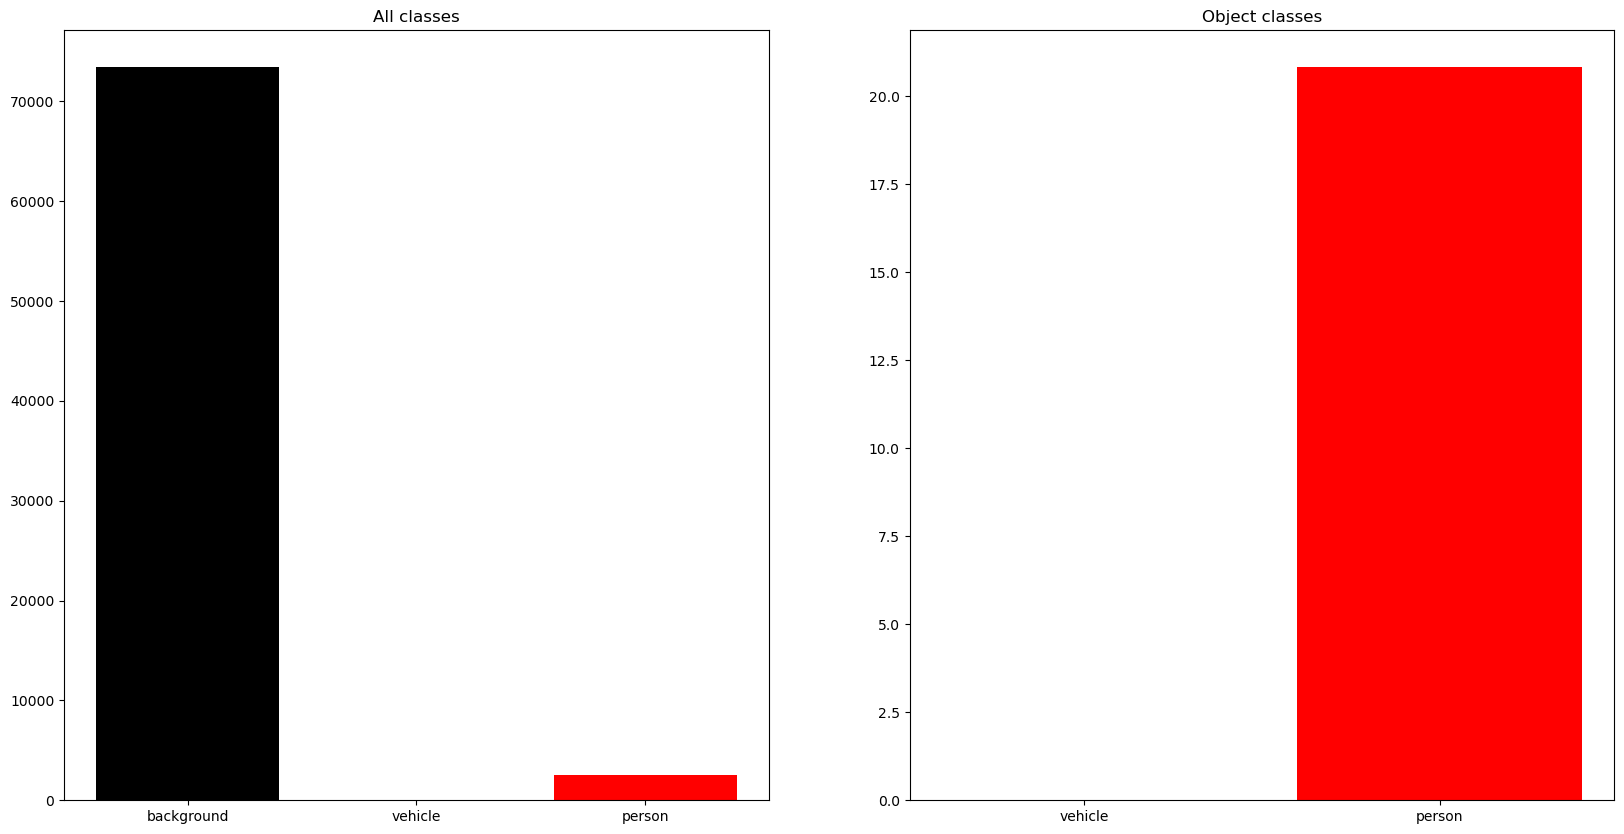

In [100]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene05.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


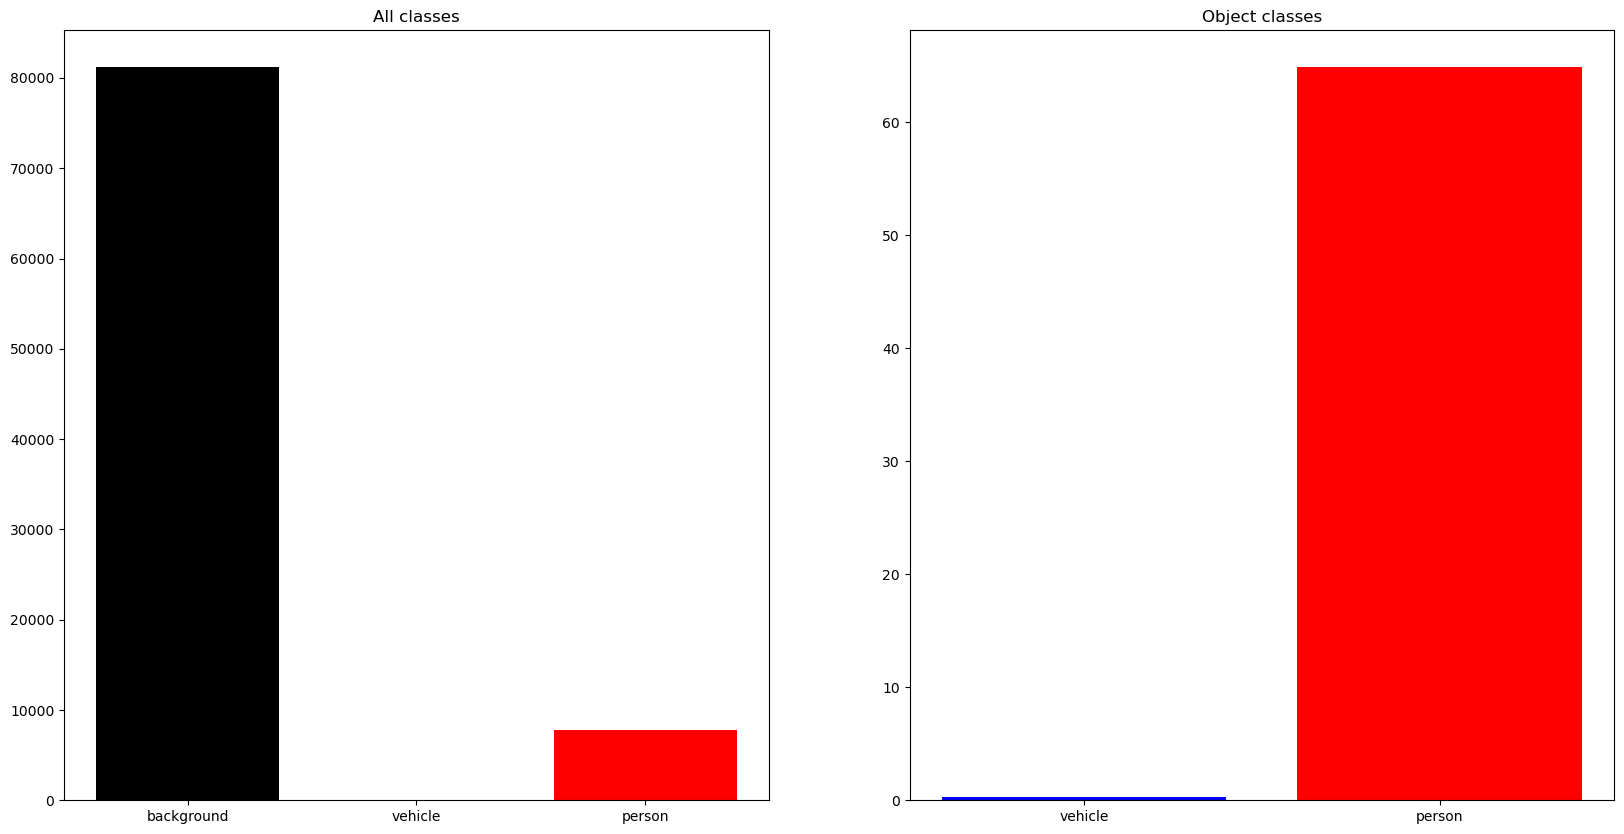

In [101]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene06.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


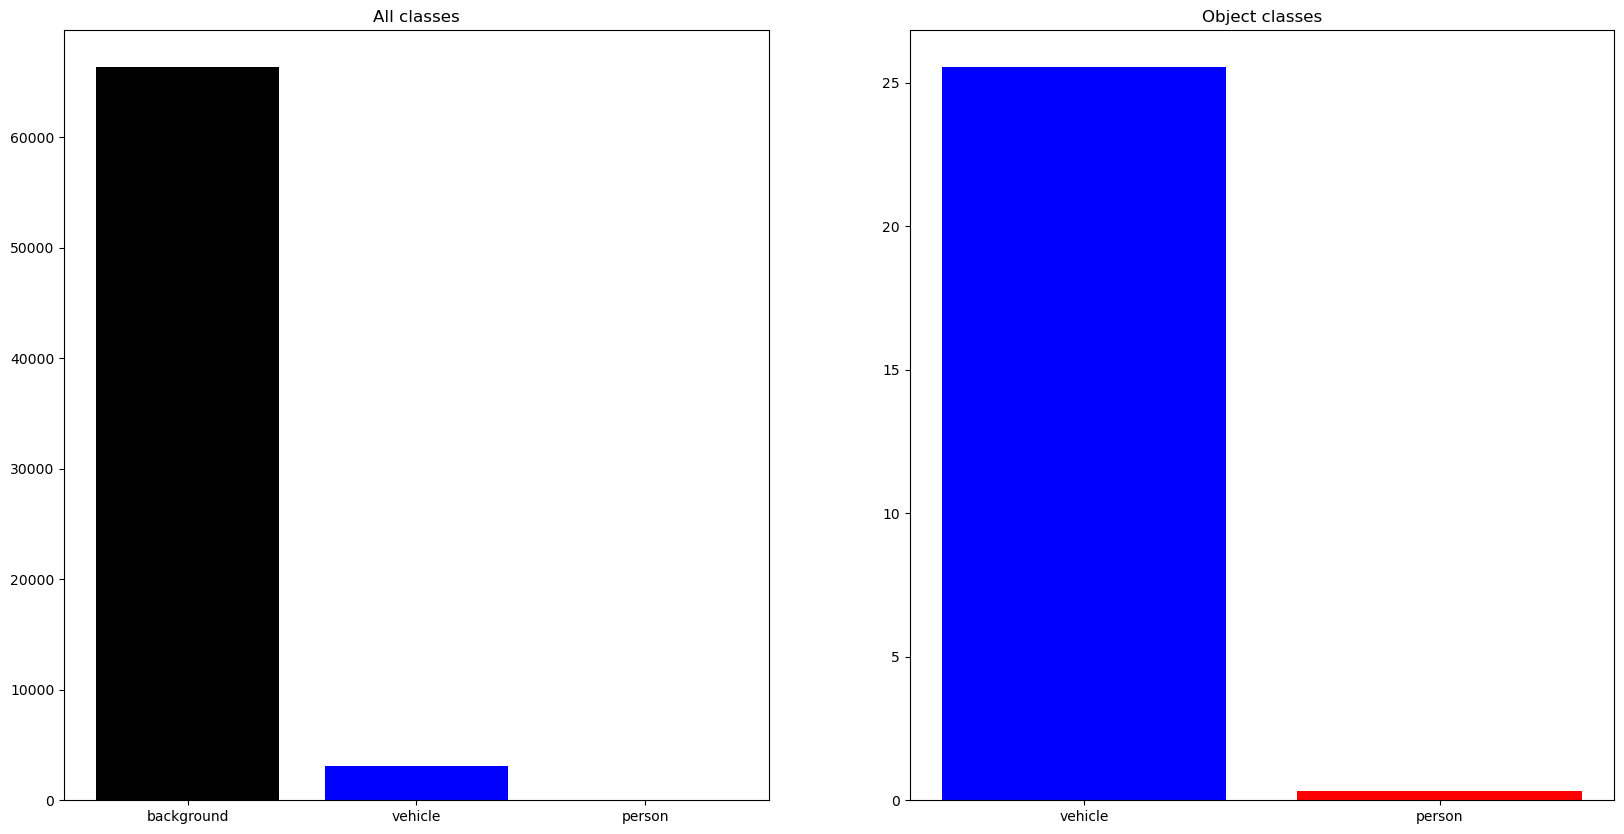

In [102]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene07.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


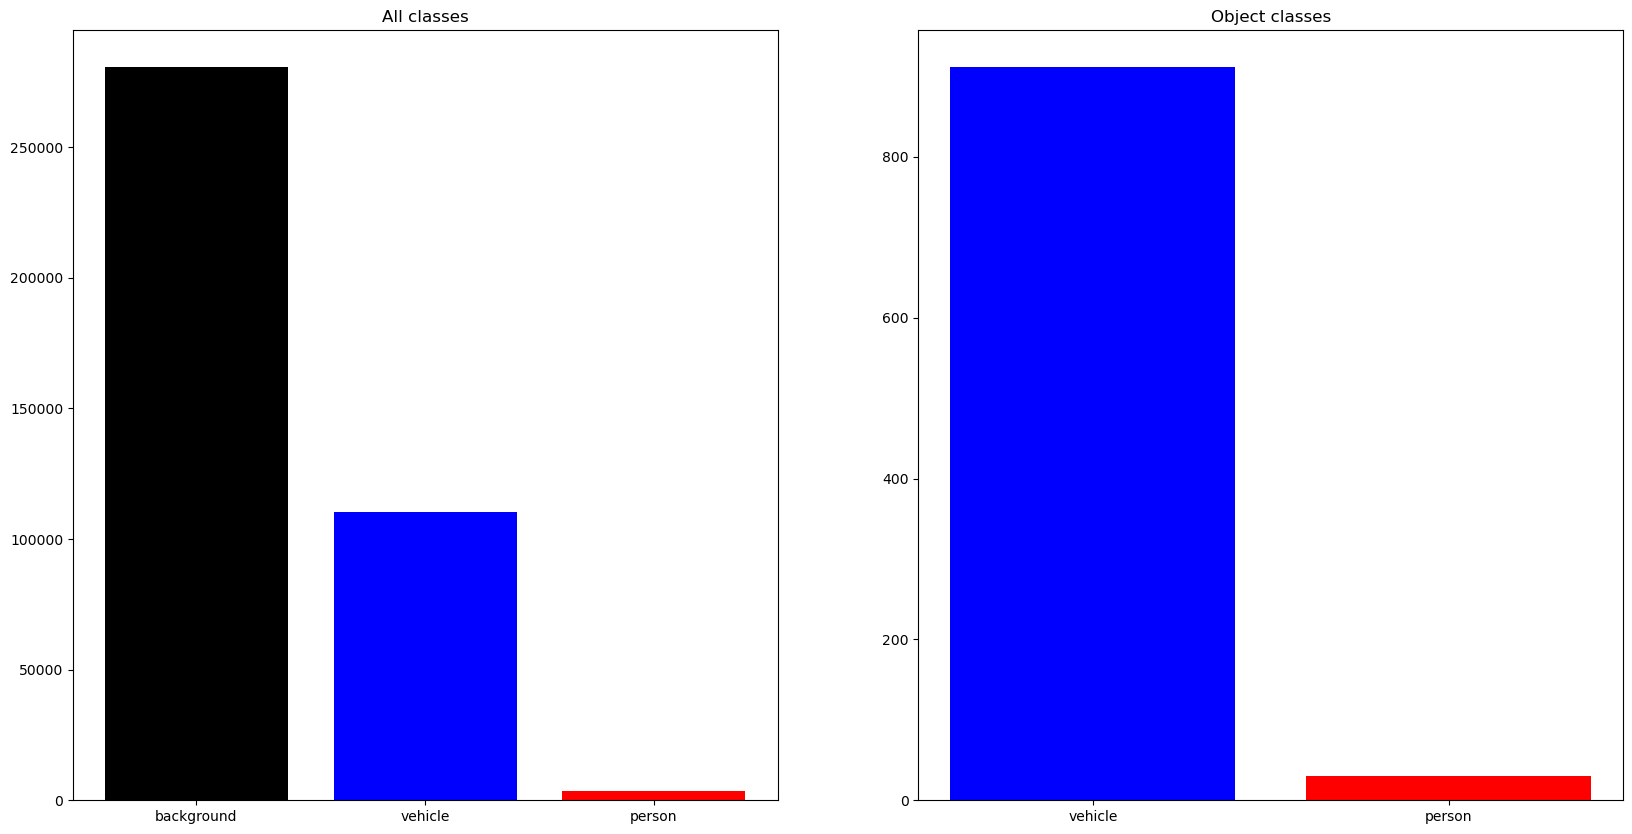

In [103]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene08.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


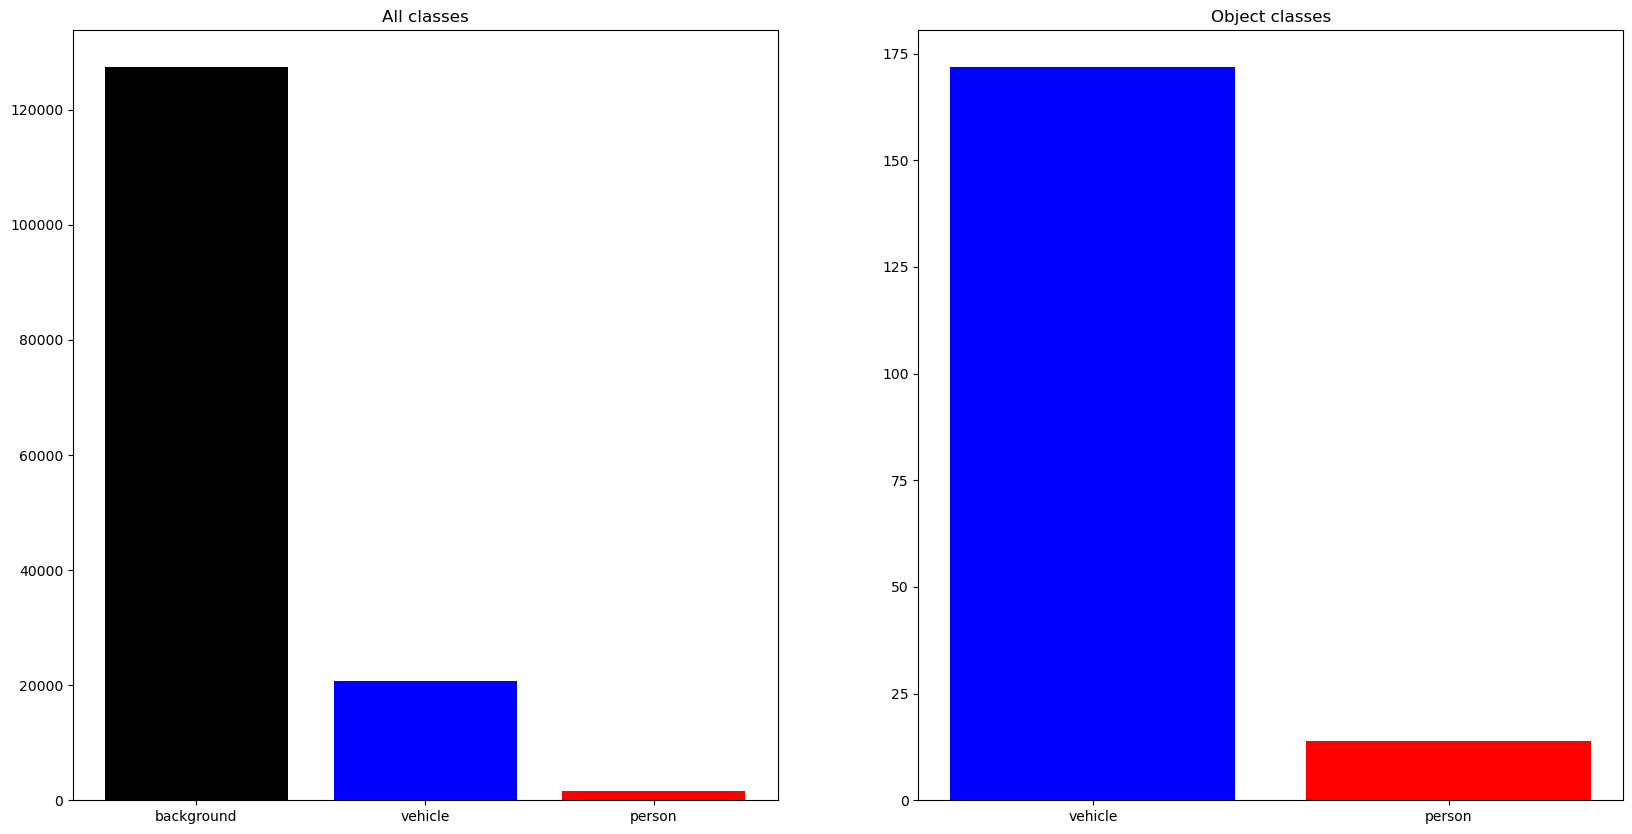

In [104]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene09.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


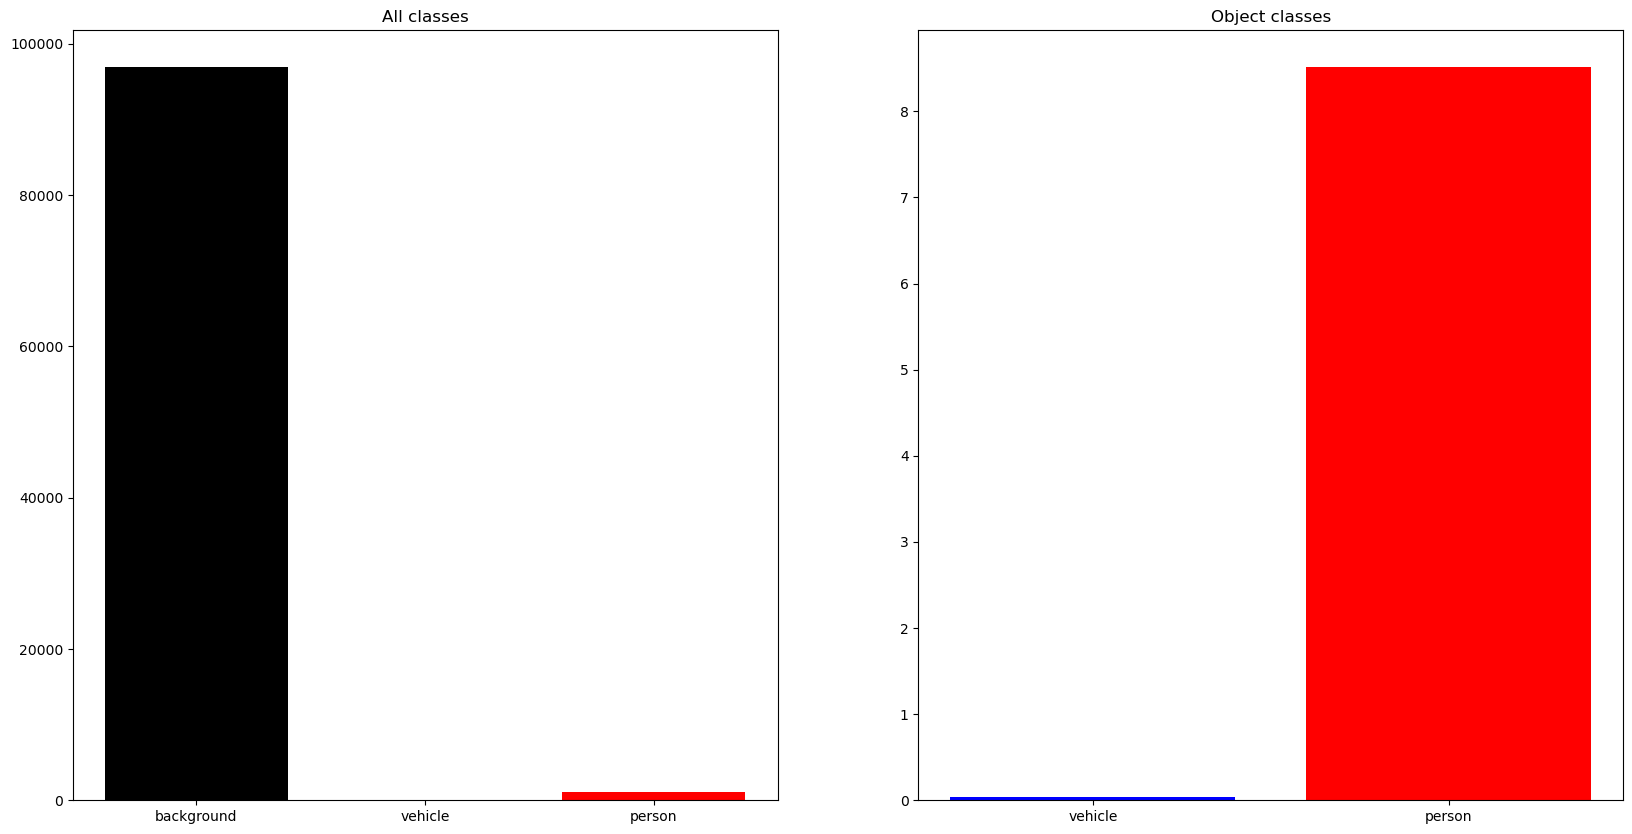

In [105]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene10.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


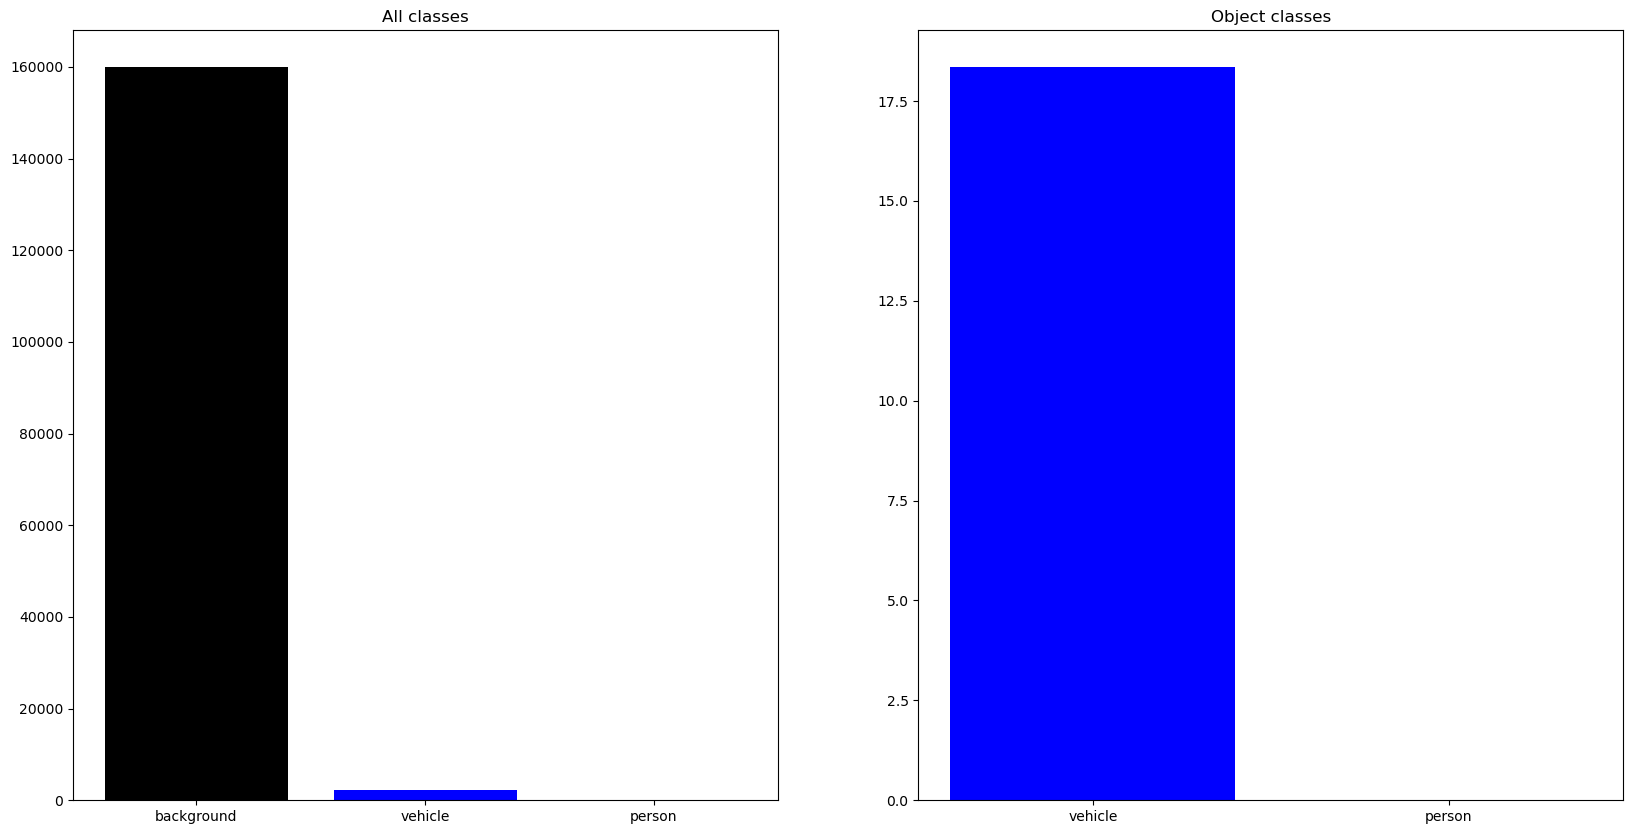

In [106]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene11.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


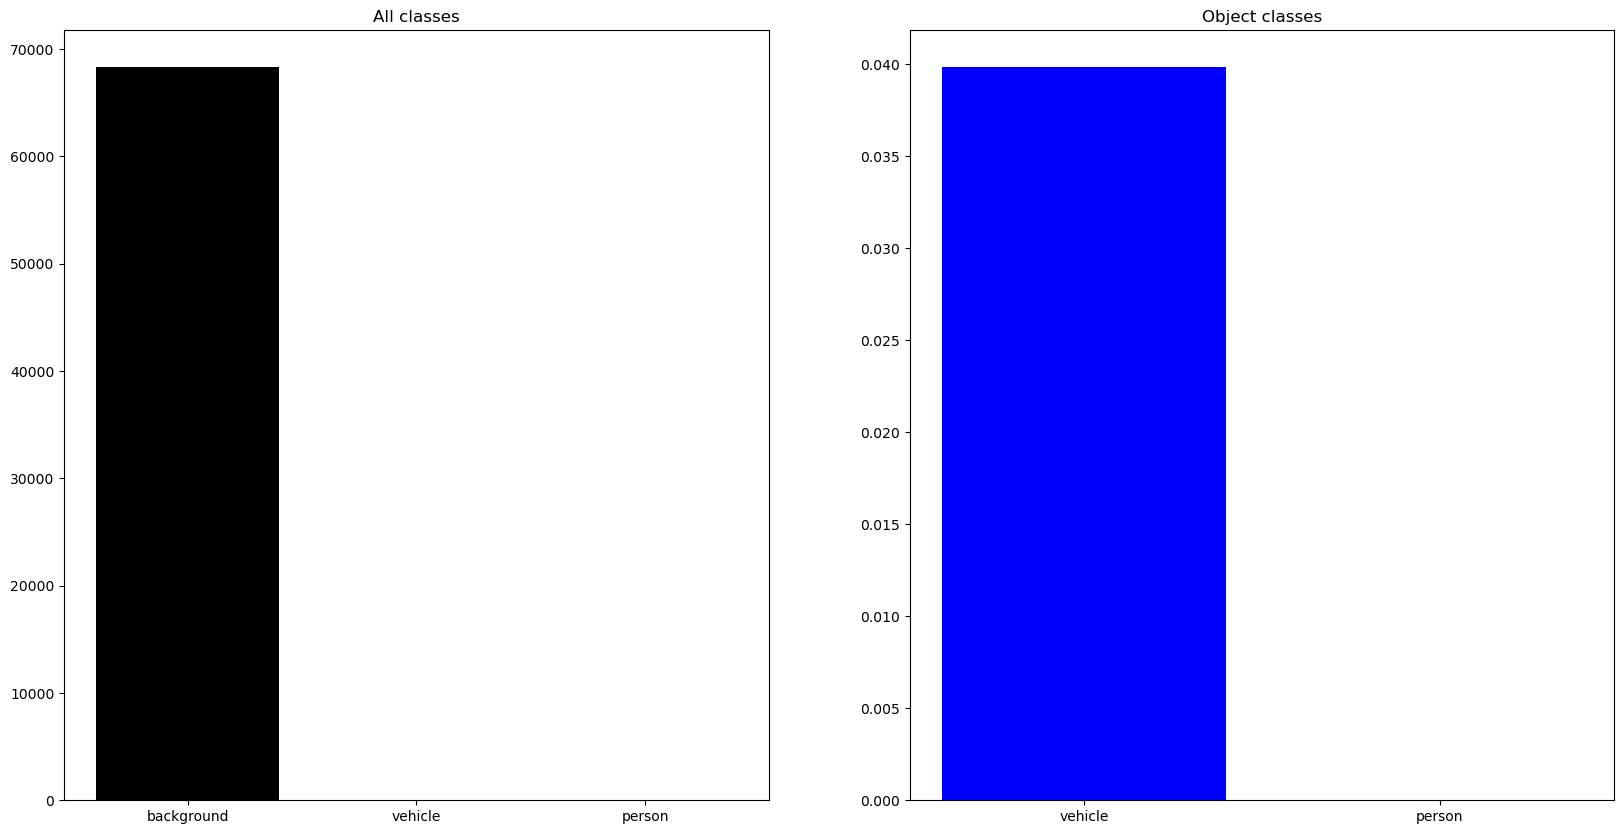

In [107]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene12.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


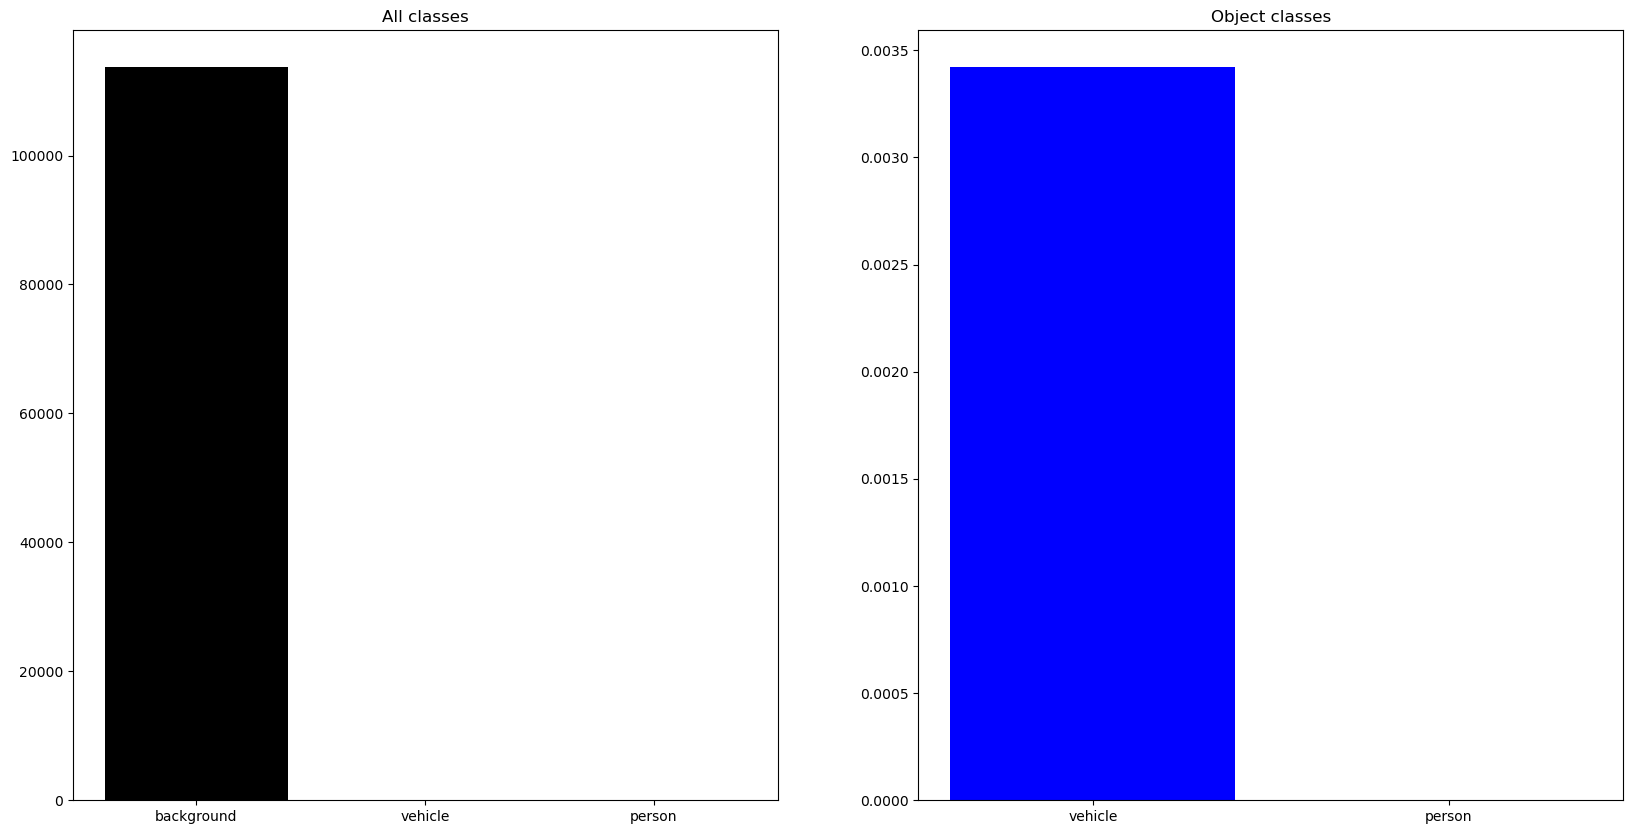

In [108]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene13.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


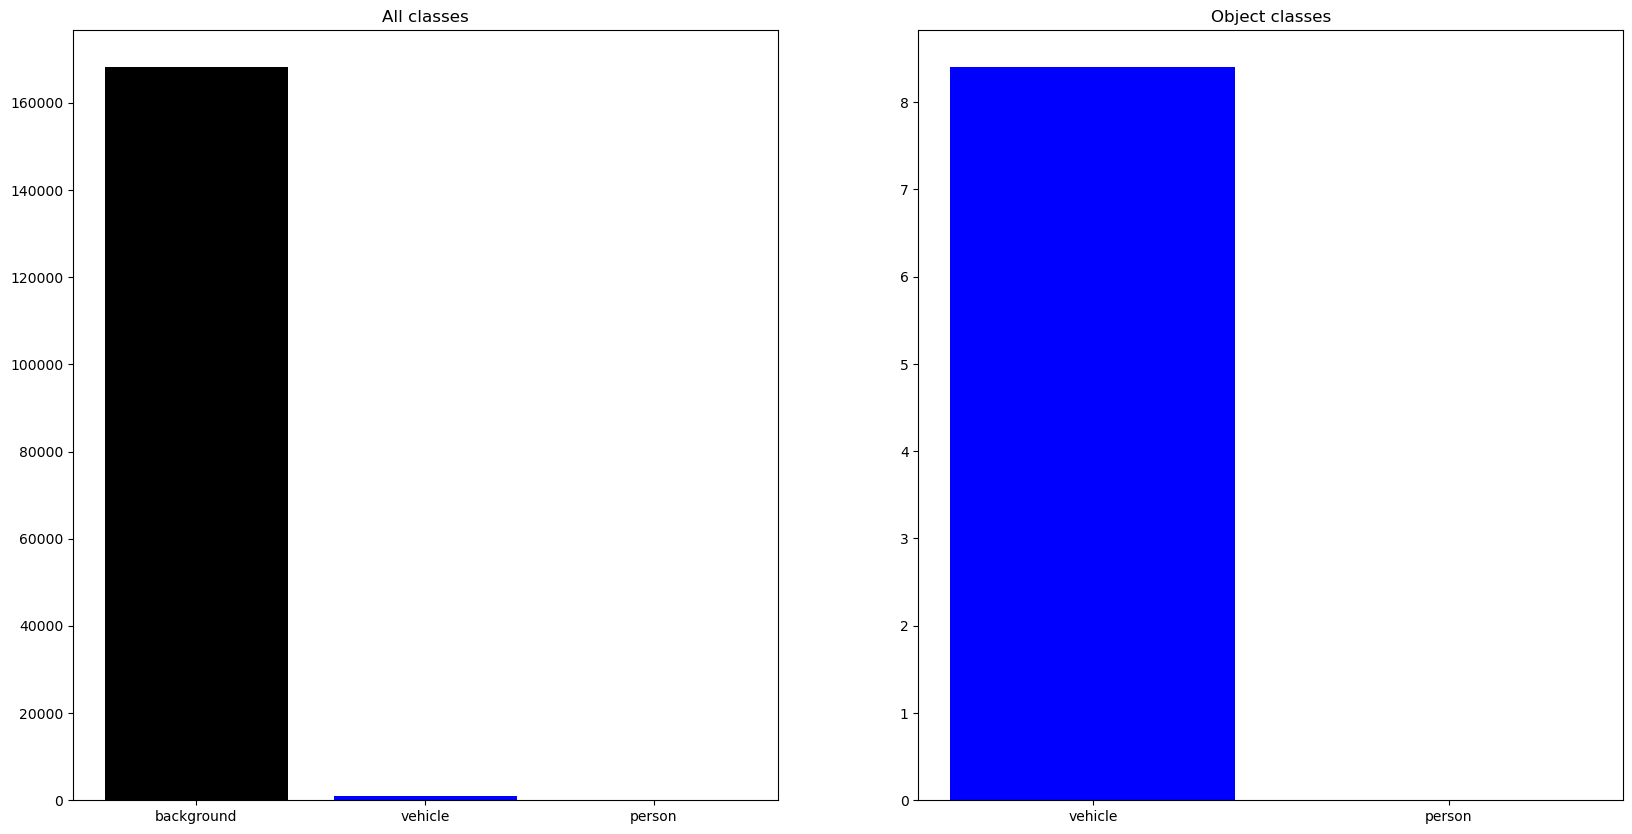

In [109]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene14.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

0it [00:00, ?it/s]

✅ Loaded model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


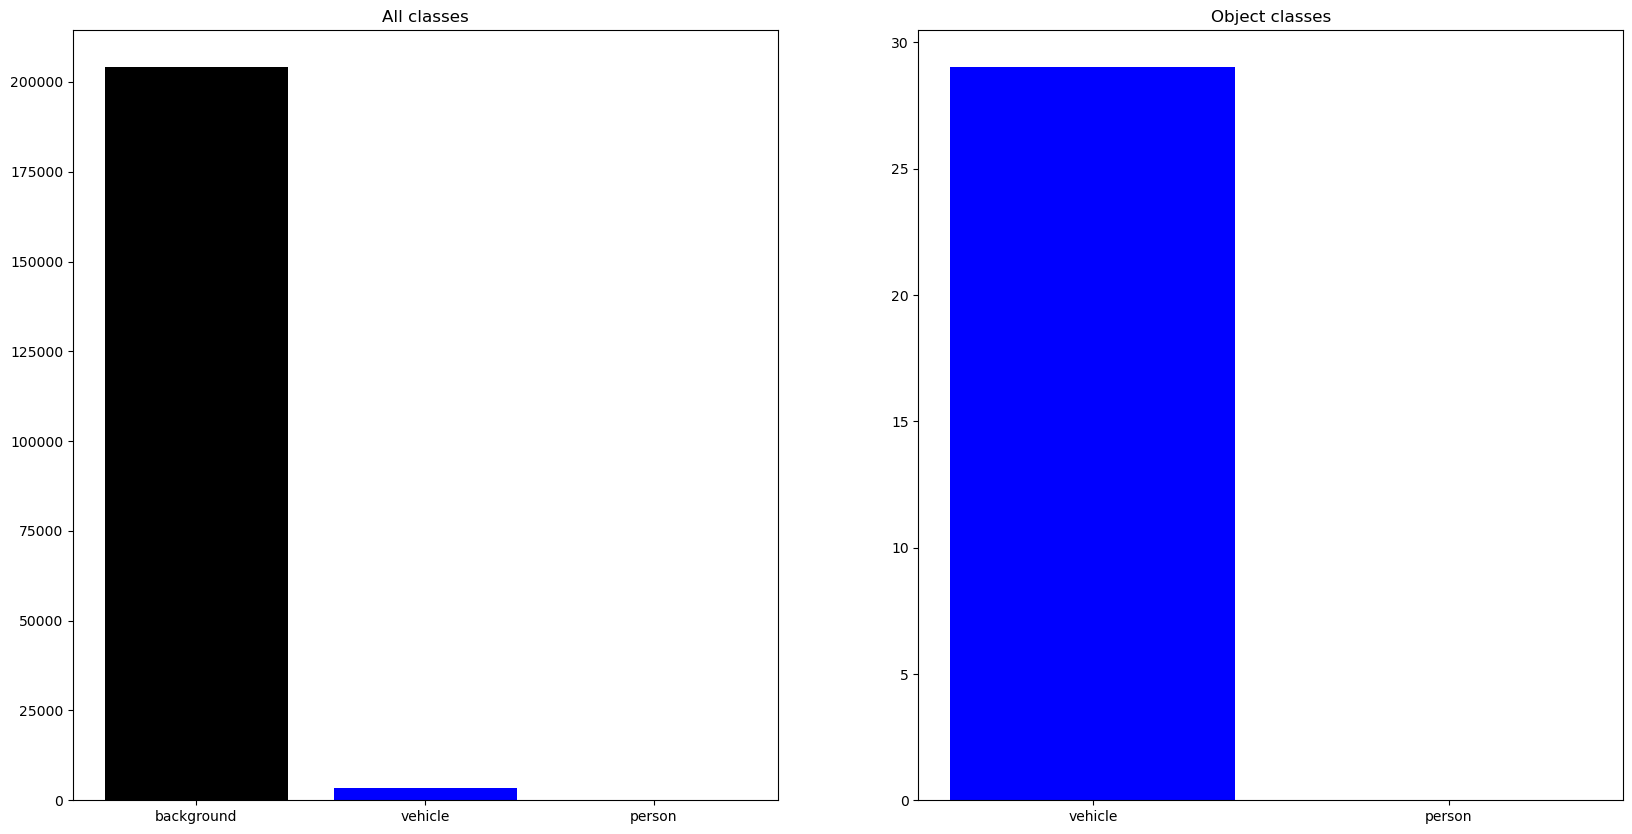

In [110]:
video_path = DATA_PATH + f"preprocessing/{scene_type}/P3Scene15.mp4"
all_class_magnitudes, object_class_magnitudes = show_ground_statistics(video_path, segmentation_model, optical_flow_model, frame_step=FRAME_STEP, split=True, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'all': all_class_magnitudes, 'object': object_class_magnitudes}

In [79]:
# Save final statistics
np.save(f"../data/preprocessing/p3_scene_statistics.npy", final_statistics)

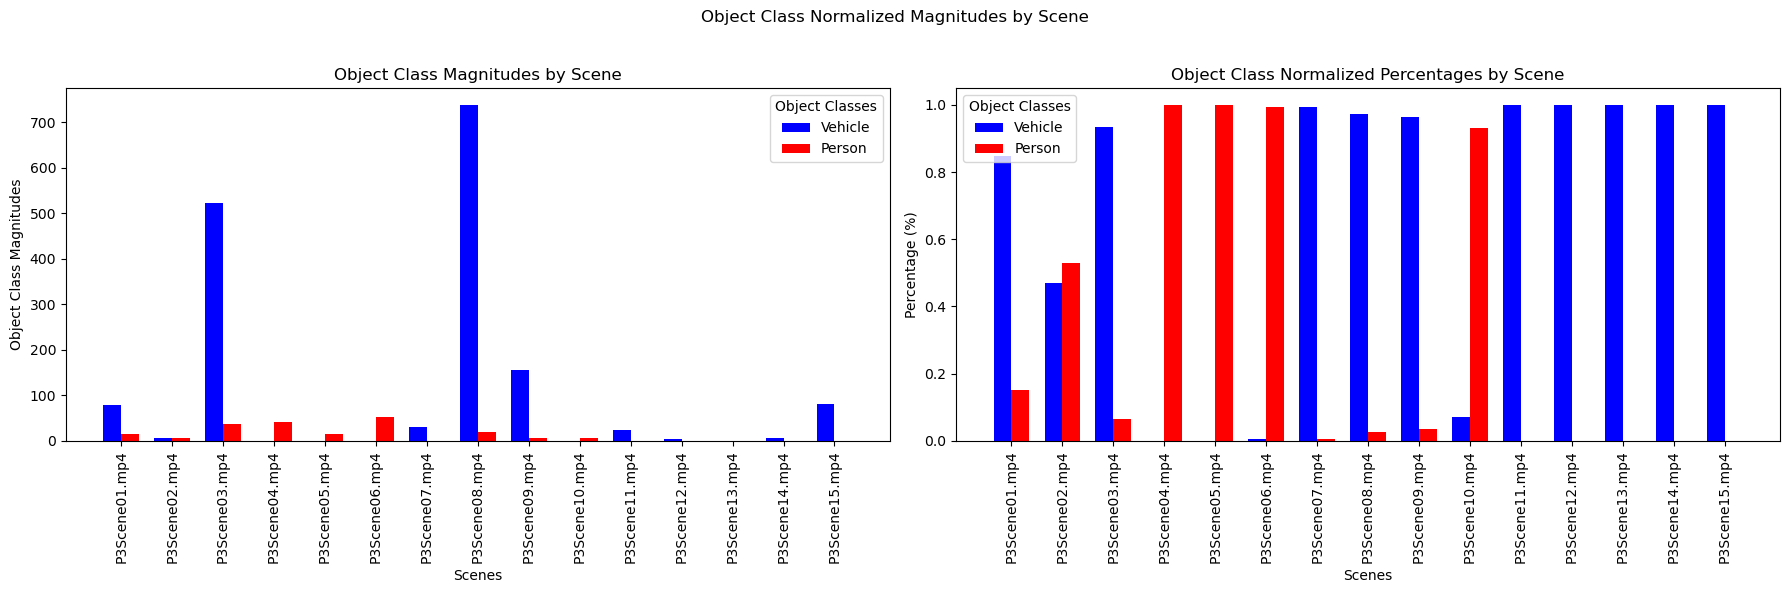

In [82]:
# Load final statistics
final_statistics = np.load(f"../data/preprocessing/p3_scene_statistics.npy", allow_pickle=True).item()

# Extract the data for object class magnitudes and scene names
scene_names = list(final_statistics.keys())
object_class_magnitudes = [data['object'] for data in final_statistics.values()]

num_scenes = len(scene_names)
num_object_classes = len(object_class_magnitudes[0])  # Assuming each entry has the same number of object classes

# Create a figure with two subplots: one for absolute magnitudes and one for percentages
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Object Class Normalized Magnitudes by Scene')
bar_width = 0.35
index = np.arange(num_scenes)
colors = ['blue', 'red']  # You should have as many colors as object classes
labels = ['Vehicle', 'Person']  # Adjust this list according to actual object classes

# Plot absolute magnitudes
for i in range(num_object_classes):
    object_class_data = [magnitudes[i] for magnitudes in object_class_magnitudes]
    axes[0].bar(index + i * bar_width, object_class_data, bar_width, label=labels[i], color=colors[i])

# Set x-axis labels and title for the first subplot
axes[0].set_xlabel('Scenes')
axes[0].set_ylabel('Object Class Magnitudes')
axes[0].set_title('Object Class Magnitudes by Scene')
axes[0].set_xticks(index + bar_width / 2 * (num_object_classes - 1))
axes[0].set_xticklabels(scene_names, rotation=90)
axes[0].legend(title='Object Classes')

# Calculate and plot normalized percentages
for i, magnitudes in enumerate(object_class_magnitudes):
    total = sum(magnitudes)
    normalized_magnitudes = [m / total for m in magnitudes]
    for j, nm in enumerate(normalized_magnitudes):
        axes[1].bar(index[i] + j * bar_width, nm, bar_width, label=labels[j] if i == 0 else "", color=colors[j])

# Set x-axis labels and title for the second subplot
axes[1].set_xlabel('Scenes')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Object Class Normalized Percentages by Scene')
axes[1].set_xticks(index + bar_width / 2 * (num_object_classes - 1))
axes[1].set_xticklabels(scene_names, rotation=90)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[:num_object_classes], labels[:num_object_classes], title='Object Classes')

# Adjust subplot layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()